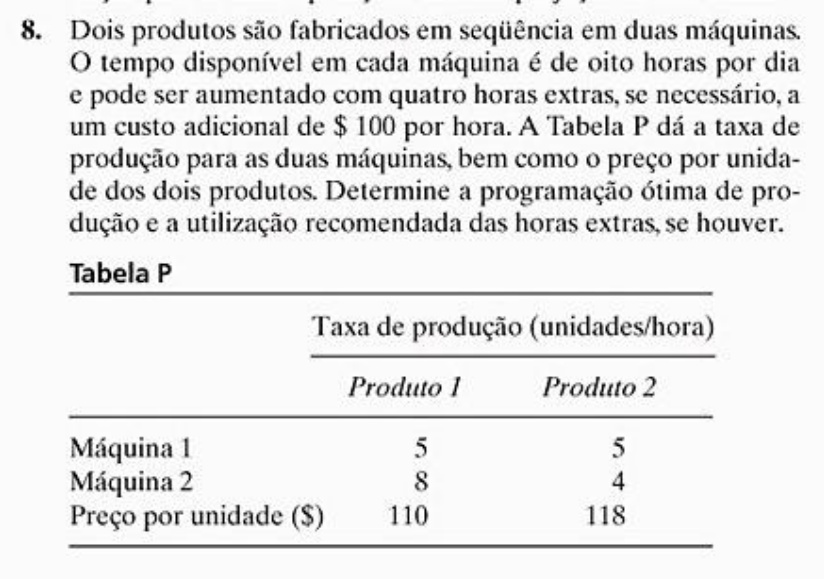

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Producao_Com_Hora_Extra')

In [3]:
# --- Parâmetros extraídos do enunciado e da Tabela P ---

# Identificadores
produtos = [1, 2]
maquinas = [1, 2]

# Dados financeiros
preco_por_unidade = {1: 110, 2: 118}
custo_por_hora_extra = 100

# Dados de tempo e capacidade
tempo_normal_diario_h = 8
tempo_extra_max_diario_h = 4

# Taxa de produção (unidades por hora)
taxa_producao = {
    1: {1: 5, 2: 8}, # Produto 1: 5 unid/h na Maq 1, 8 unid/h na Maq 2
    2: {1: 5, 2: 4}  # Produto 2: 5 unid/h na Maq 1, 4 unid/h na Maq 2
}

# Conversão para tempo por unidade (horas por unidade) para facilitar as restrições
# Tempo = 1 / Taxa
tempo_por_unidade_h = {
    p: {m: 1 / taxa_producao[p][m] for m in maquinas} for p in produtos
}

In [4]:
# 1. Variáveis de Decisão
# Quantidade de cada produto a ser produzida
producao_diaria = model.continuous_var_dict(produtos, name='P')

# Horas extras a serem utilizadas em cada máquina
horas_extras_utilizadas = model.continuous_var_dict(maquinas, name='H_extra', lb=0)


# 2. Função Objetivo
# Maximizar o Lucro Total = (Receita de Vendas) - (Custo das Horas Extras)
expressao_receita = (preco_por_unidade[p] * producao_diaria[p] for p in produtos)
receita_total = model.sum(expressao_receita)

expressao_custo_extra = (custo_por_hora_extra * horas_extras_utilizadas[m] for m in maquinas)
custo_total_extra = model.sum(expressao_custo_extra)

lucro_total = receita_total - custo_total_extra
model.maximize(lucro_total)


# 3. Restrições

# Restrição 1: Capacidade de cada Máquina
# O tempo total de produção em cada máquina não pode exceder o tempo normal + horas extras.
# Tempo_Produção <= Tempo_Normal + Horas_Extras  =>  Tempo_Produção - Horas_Extras <= Tempo_Normal
for m in maquinas:
    expressao_tempo_usado = (tempo_por_unidade_h[p][m] * producao_diaria[p] for p in produtos)
    soma_tempo_usado = model.sum(expressao_tempo_usado)
    restr_capacidade_logica = soma_tempo_usado - horas_extras_utilizadas[m] <= tempo_normal_diario_h
    model.add_constraint(restr_capacidade_logica, ctname=f'capacidade_maq_{m}')

# Restrição 2: Limite de Horas Extras
# Cada máquina pode ter no máximo 4 horas extras.
for m in maquinas:
    restr_limite_extra_logica = horas_extras_utilizadas[m] <= tempo_extra_max_diario_h
    model.add_constraint(restr_limite_extra_logica, ctname=f'limite_extra_maq_{m}')

In [5]:
# Define um tempo limite para o solver (opcional)
model.parameters.timelimit = 120

# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
if solucao:
    lucro_maximo = model.objective_value
    print(f"Lucro Diário Máximo: ${lucro_maximo:,.2f}\n")

    print("--- Programação Ótima de Produção ---")
    for p in produtos:
        prod_val = producao_diaria[p].solution_value
        print(f"  - Produto {p}: {prod_val:,.2f} unidades/dia")

    print("\n--- Utilização Recomendada de Horas Extras ---")
    for m in maquinas:
        he_val = horas_extras_utilizadas[m].solution_value
        if he_val > 1e-6:
            print(f"  - Máquina {m}: {he_val:,.2f} horas/dia")
        else:
            print(f"  - Máquina {m}: Nenhuma hora extra necessária.")
else:
    print("Não foi possível encontrar uma solução.")

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               120
Tried aggregator 1 time.
LP Presolve eliminated 2 rows and 0 columns.
Reduced LP has 2 rows, 4 columns, and 6 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)

Iteration log . . .
Iteration:     1   Dual infeasibility =           188.000000
Iteration:     3   Dual objective     =          6232.000000

------ SOLUÇÃO ÓTIMA ------

Lucro Diário Máximo: $6,232.00

--- Programação Ótima de Produção ---
  - Produto 1: 56.00 unidades/dia
  - Produto 2: 4.00 unidades/dia

--- Utilização Recomendada de Horas Extras ---
  - Máquina 1: 4.00 horas/dia
  - Máquina 2: Nenhuma hora extra necessária.
